<a href="https://colab.research.google.com/github/BeatrizIJB/TensorFlow/blob/master/XII_SymBio_Workshop_Pytorch_Complete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# XII Symposium on Bioengineering Workshop: **Deep Learning from Biomedical Data**

[COMPLETE VERSION]

**João Ribeiro Pinto**<br>
VCMI, INESC TEC<br>
joao.t.pinto@inesctec.pt

In [ ]:
# These are the imports we will need for this notebook
import math
import sys
import numpy as np
import pandas as pd
import pickle
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset
from matplotlib import pyplot as pl
from sklearn.metrics import balanced_accuracy_score, confusion_matrix

## **Data and Task**

**PTB-XL Database**

The PTB-XL includes over 21 thousand ECG signals, from over 18 thousand subjects, each 10 seconds long at either 100 Hz or 500 Hz. These signals are labelled as healthy or as having certain cardiac ailments grouped into superclasses (Myocardial Infarction, ST/T Change, Conduction Disturbance, or Hypertrophy).

The entire dataset is available at Physionet, a repository with several free medical datasets of physiological signals:
https://www.physionet.org/content/ptb-xl/1.0.1/

The subset of data we will use here is in a pre-prepared pickle file train.py. Let's read it:


In [ ]:
DATA_FILE = 'https://paginas.fe.up.pt/~jtpinto/XIISymBio/train.pk'

X_train, y_train = pd.read_pickle(DATA_FILE)

print('X shape', X_train.shape)
print('y shape', y_train.shape)

X shape (4921, 1, 1000)
y shape (4921,)


Let's look at some signals:

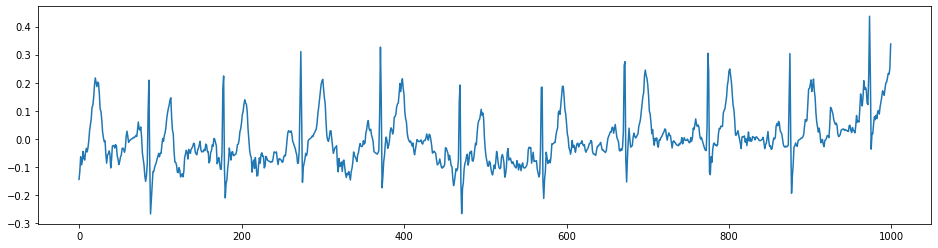

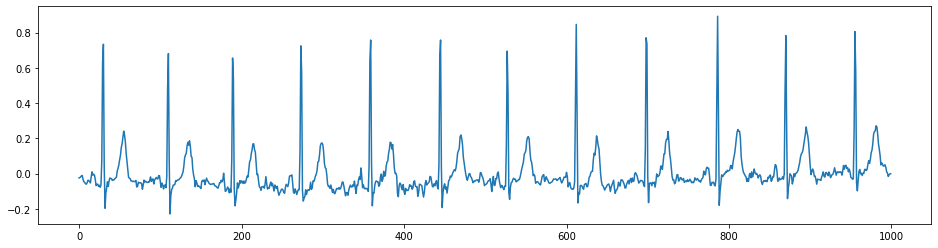

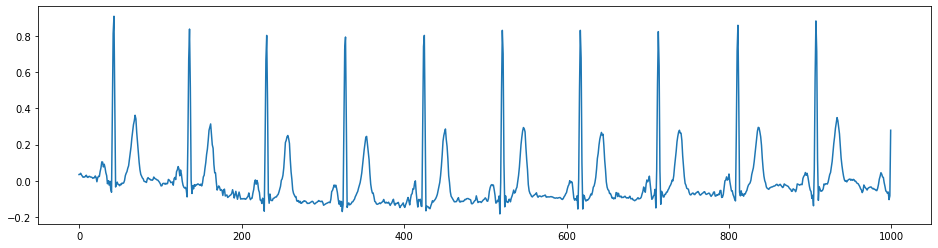

In [ ]:
pl.figure(figsize=[16,4])
pl.plot(X_train[0, 0])
pl.show()

pl.figure(figsize=[16,4])
pl.plot(X_train[10, 0])
pl.show()

pl.figure(figsize=[16,4])
pl.plot(X_train[20, 0])
pl.show()

And let's check out some metrics that are always useful:

In [ ]:
print('max', np.max(X_train, axis=2), '\n')
print('min', np.min(X_train, axis=2), '\n')
print('mean', np.mean(X_train, axis=2), '\n')
print('std', np.std(X_train, axis=2), '\n')
print('nans', np.sum(np.isnan(X_train)), '\n')

max [[0.437]
 [0.239]
 [1.241]
 ...
 [0.31 ]
 [0.352]
 [1.199]] 

min [[-0.268]
 [-0.179]
 [-0.261]
 ...
 [-0.228]
 [-0.16 ]
 [-0.514]] 

mean [[-0.00283 ]
 [-0.004349]
 [ 0.00347 ]
 ...
 [-0.002548]
 [-0.003515]
 [-0.010336]] 

std [[0.08868913]
 [0.05535647]
 [0.17552109]
 ...
 [0.05908138]
 [0.08122199]
 [0.21377762]] 

nans 0 



Let's look at the annotations:

In [ ]:
labels, counts = np.unique(y_train, return_counts=True)
print('labels', labels)
print('counts', counts)

labels ['CD' 'HYP' 'MI' 'NORM' 'STTC']
counts [ 532  160  779 2727  723]


'CD', 'HYP', 'MI', and 'STTC', correspond to the aforementioned disease superclasses. 'NORM' corresponds to normal cases.

**Our task: based on a signal, accurately predict the corresponding label.**

For that, we are going to implement a simple convolutional neural network using Pytorch.

In [ ]:
del X_train, y_train

## **Pytorch**

Just like Tensorflow and Keras, Pytorch is a python package that includes a lot of the tools we frequently need when working with Deep Learning: typical models,
layers, optimisers, and everything else...

Although very powerful, Pytorch is very nice to use since it aims to be as close as possible to Numpy. You will soon see the similarities.

We commonly organise our Pytorch-based code into very specific classes and functions, that help us divide the whole code according to its place in the deep learning pipeline. Each class/function is typically in a separate .py file, but we can create them here. These are:

- the **Dataset** class: which groups everything related with reading data and labels, converting formats, preprocessing, and organising everything to be given correctly to the model;

- the **Model** class: where we define the structure of the model, the layers, activations, and also the path data will take when going through our model;

- the **train routine** function: which defines the iterative loop followed during training, loading data from the Dataset, passing it through the Model, calculating losses, computing respective gradients and updating weights, as well as checking out evaluation performance in the train and validation sets;

- and possibly others, if you want to do more specific stuff...

Of course, all of these are called by a very simple main script.

### Classes and functions

Let's begin by creating our own classes and functions for the task at hand.

#### Dataset class

The dataset class should have, at least, three functions:

- **\_\_init\_\_(self, ...)** - where important attributes are initialised (and maybe data is loaded, if the dataset is small);
- **\_\_get_item\_\_(self, index)** - for an index in [0, N_samples[ it should load, prepare, and deliver the data sample and label corresponding to that index;
- **\_\_len\_\_(self)** - it should return the length of the dataset, i.e. N_samples.

And any other functions related to data preprocessing, normalisation, or preparation that are used by these three.

In [ ]:
class Dataset(Dataset):

    def __init__(self, data_file):
        self.X, self.y = pd.read_pickle(data_file)  # read the data into variables

    def preprocess_x(self, X):
        return (X - np.mean(X)) / np.std(X)  # normalise data to zero mean and unit variance

    def preprocess_y(self, y):
        if y == 'NORM':   # normalise labels to [0, N_classes[
            return 0
        elif y == 'CD':
            return 1
        elif y == 'HYP':
            return 2
        elif y == 'MI':
            return 3
        elif y == 'STTC':
            return 4

    # For data augmentation
    def data_augmentation(self, x):
        da_methods = [self.baseline_wander, self.random_noise, self.amplitude_rescaling]
        method = np.random.choice(da_methods)  # choose randomly one of the methods
        return method(x)

    def baseline_wander(self, x):
        # Adds a slight undulation to the signal
        sine = 1.0 * np.sin(2 * np.pi * 0.5 * (np.arange(1000)/100.0) + np.random.random())
        return x + sine

    def random_noise(self, x):
        # Adds random noise to the signal
        noise = 0.5 * (np.random.random(size=(1000,)) - 0.5)
        return x + noise

    def amplitude_rescaling(self, x):
        # Randomly rescales the amplitude of the signal
        factor = np.random.uniform(low=0.5, high=2.0)
        return x * factor

    def __getitem__(self, index):
        x = self.preprocess_x(self.X[index])
        y = self.preprocess_y(self.y[index])
        x = self.data_augmentation(x)
        return (x, y)

    def __len__(self):
        return self.X.shape[0]

#### Model class

The model class should have at least three functions as well:

- **\_\_init\_\_(self, ...)** - it is used to create the different parts of the model (the convolutional part, the fully-connected part, ...) through which the data will run, including all the layers that make up each of those parts;
- **forward(self, x)** - it calls the parts of the model defined in \_\_init\_\_ with the data x, performing necessary operations, overall defining the path x will take throughout the model until the final output;
- **predict(self, x)** - similar to forward, but typically includes a final softmax activation to transform the output logits into output class probabilities.

It is also common to have other functions, including typically get_flat_dim, a function to compute the flattened dimensions of data that will be received by the fully-connected part.

In [ ]:
class Model(nn.Module):

    def __init__(self, n_classes=5, dropout=.0):
        super(Model, self).__init__()

        # Convolutional part:
        self.convnet = nn.Sequential(nn.Conv1d(1, 16, 5, stride=1, padding=0),
                                     nn.ReLU(),
                                     nn.MaxPool1d(4),
                                     nn.Conv1d(16, 16, 5, stride=1, padding=0),
                                     nn.ReLU(),
                                     nn.MaxPool1d(4),
                                     nn.Conv1d(16, 32, 5, stride=1, padding=0),
                                     nn.ReLU(),
                                     nn.MaxPool1d(4),
                                     nn.Conv1d(32, 32, 5, stride=1, padding=0),
                                     nn.ReLU()
                                    )

        # Fully-connected part:
        self.fc = nn.Sequential(nn.Linear(self.get_flat_dim(self.convnet, 1000), 100),
                                nn.ReLU(),
                                nn.Dropout(p=dropout),
                                nn.Linear(100, n_classes)
                               )

    def get_flat_dim(self, convnet, input_size):
        # Computes the size of the output of the convolutional part, which is
        # the input to the fully-connected part.
        last_conv_n_filters = 0
        for layer in convnet:
            if isinstance(layer, nn.Conv1d):
                kernel_size = layer.kernel_size[0]
                padding = layer.padding[0]
                stride = layer.stride[0]
                input_size = int(math.floor((input_size + 2 * padding - kernel_size)/(1. * stride) + 1))
                last_conv_n_filters = layer.out_channels
            elif isinstance(layer, nn.MaxPool1d):
                kernel_size = layer.kernel_size
                stride = layer.stride
                input_size = int(math.floor((input_size - kernel_size)/(1. * stride) + 1))
        return input_size * last_conv_n_filters

    def forward(self, x):
        h = self.convnet(x)
        h = h.view(h.size(0), -1)  # Flatten features from convnet
        output = self.fc(h)
        return output
    
    def predict(self, X):
        logits = self.forward(X)
        probs = nn.functional.softmax(logits, dim=1)
        return probs

#### Train routine

The **train_model** function should define the training routine for the model:
- It should have a for loop for each epoch (train iteration);
- Each epoch should have a first stage of optimisation, then a stage of evaluation with the train and validation sets;
- Each stage should have its own for loop that will iterate through the mini-batches of data given by the data loader;
- To compute gradients and update model parameters, model.train() should be used before the optimisation stage, which should end with optimiser.zero_grad(), loss.backward(), and optimiser.step();
- The evaluation stage should begin with torch.no_grad() and model.eval(), so that gradients are not computed, and the model is not updated;
- Throughout this, you should save the evolution of train and validation loss and accuracy, and perhaps use them to routinely save the best model yet, or stop training when the model is no longer improving.

In [ ]:
def train_model(model, loss_fn, optimiser, train_loader, n_epochs, device, patience=np.inf, valid_loader=None, filename=None):
    # repeat training for the desired number of epochs
    train_hist = []
    train_acc = []
    valid_hist = []
    valid_acc = []

    # For early stopping:
    plateau = 0  
    best_valid_loss = None

    print(model)  # Print the structure of the model

    for epoch in range(n_epochs):
        print('Epoch {}/{}'.format(epoch + 1, n_epochs))
    
        # training loop
        model.train()  # set model to training mode (affects dropout and batch norm.)
        for i, (X, y) in enumerate(train_loader):
            X = X.float().to(device)
            y = y.to(device)
            
            ypred = model(X)          # forward pass

            loss = loss_fn(ypred, y)  # compute the loss

            optimiser.zero_grad()     # set all gradients to zero (otherwise they are accumulated)
            loss.backward()           # backward pass (i.e. compute gradients)
            optimiser.step()          # update the parameters
        
            # display the mini-batch loss
            sys.stdout.write("\r" + '........ Mini-batch no. {} loss: {:.4f}'.format(i+1, loss.item()))
            sys.stdout.flush()

        # compute the training and validation losses to monitor the training progress (optional)
        print()
        with torch.no_grad():  # now we are doing inference only, so we do not need gradients
            model.eval()       # set model to inference mode (affects dropout and batch norm.)
        
            train_loss = 0.
            train_corrects = 0  # Train samples the model labelled correctly (for the accuracy)
            train_total = 0     # Total train samples

            for i, (X, y) in enumerate(train_loader):
                X = X.float().to(device)
                y = y.to(device)
                
                ypred = model(X)                 # forward pass

                train_loss += loss_fn(ypred, y)  # accumulate the loss of the mini-batch

                train_corrects += (torch.argmax(ypred, 1) == y).float().sum()
                train_total += y.shape[0]

            train_loss /= i + 1
            train_hist.append(train_loss.item())
            acc = train_corrects / train_total
            train_acc.append(acc)

            print('.... Train loss: {:.4f} :: Acc {:.4f}'.format(train_loss.item(), acc))
        

            if valid_loader is None:
                print()
                continue
        
            valid_loss = 0.
            valid_corrects = 0  # Validation samples the model labelled correctly (for the accuracy)
            valid_total = 0     # Total validation samples

            for i, (X, y) in enumerate(valid_loader):
                X = X.float().to(device)
                y = y.to(device)
            
                ypred = model(X)                 # forward pass

                valid_loss += loss_fn(ypred, y)  # accumulate the loss of the mini-batch

                valid_corrects += (torch.argmax(ypred, 1) == y).float().sum()
                valid_total += y.shape[0]

            valid_loss /= i + 1
            valid_hist.append(valid_loss.item())
            acc = valid_corrects / valid_total
            valid_acc.append(acc)

            print('.... Valid loss: {:.4f} :: Acc {:.4f}'.format(valid_loss.item(), acc))

        # Saving the model and history after the first epoch:
        if best_valid_loss is None:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), filename + '.pth')
            with open(filename + '_trainhist.pk', 'wb') as hf:
                pickle.dump({'loss': train_hist, 'acc': train_acc}, hf)
            with open(filename + '_validhist.pk', 'wb') as hf:
                pickle.dump({'loss': valid_hist, 'acc': valid_acc}, hf)
            print('.... Saving...')
        # Saving the best model so far:
        elif valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), filename + '.pth')
            with open(filename + '_trainhist.pk', 'wb') as hf:
                pickle.dump({'loss': train_hist, 'acc': train_acc}, hf)
            with open(filename + '_validhist.pk', 'wb') as hf:
                pickle.dump({'loss': valid_hist, 'acc': valid_acc}, hf)
            plateau = 0
            print('.... Saving...')
        # Stopping the train after some epochs without improvement:
        else:
            plateau += 1
            if plateau >= patience:
                print('.... Early stopping the train.')
                return train_hist, valid_hist, train_acc, valid_acc

    return train_hist, valid_hist, train_acc, valid_acc

### Main training script

Now, we call everything on a main training script.

We first define some useful variables, including the number of epochs, the size of each mini-batch, and the fraction of data to be used for validation. 

Let's also define a filename to save the trained model.

We can also set up a GPU to be used (if we have one).


In [ ]:
N_EPOCHS = 500       # Maximum number of training iterations
BATCH_SIZE = 32      # Size of each mini-batch
PATIENCE = 25        # Max. number of epochs without improvement before termination
VALID_SPLIT = 0.1    # Fraction of training data to be used for validation

SAVE_MODEL = 'trained_model'

DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'

Then, we go to the data. We initialise the train dataset, and divide it randomly into a train set and a validation set.

Data loaders are important classes that will use the Dataset object to build adequate mini-batches.

In [ ]:
# Building the dataset object:
train_set = Dataset(DATA_FILE)

# Dividing randomly into training and validation splits:
indices = np.arange(len(train_set))
split = int(np.floor(VALID_SPLIT * len(indices))) 
np.random.seed(42)  # random shuffle seed for split reproducibility
np.random.shuffle(indices)
train_indices, valid_indices = indices[split:], indices[:split]

train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)
valid_sampler = torch.utils.data.sampler.SubsetRandomSampler(valid_indices)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                           shuffle=False, num_workers=1,
                                           sampler=train_sampler)

valid_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                           shuffle=False, num_workers=1,
                                           sampler=valid_sampler)

After the data is prepared, we go to the model.

First, we initialise it, giving it the appropriate input variables according to our task. If we use a GPU, we have to remember to send it to(DEVICE) after creation.

Then, we instantiate a loss function. There are many different ones, but CrossEntropyLoss is the most common for typical classification problems.

Finally, we create an optimiser. Adam is the standard one. It will need to receive the model's parameters, an initial learning rate (typically 1e-3 or 1e-4), and l1-regularisation weight (typically between 1e-3 and 1e-5, or 0).

In [ ]:
# Initialising the model, the loss, and the optimiser
model = Model(n_classes=5, dropout=0.2).to(DEVICE)

class_weights = torch.FloatTensor([1./2727, 1./532, 1./160, 1./779, 1./723]).to(DEVICE)
loss_fn = nn.CrossEntropyLoss(weight=class_weights) 

optimiser = optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.0)  # lr - learning rate, weight_decay - l1-regularisation

After all this, we give everything to the train_model function and wait...

In [ ]:
# Training the model:
train_hist, valid_hist, train_acc, valid_acc = train_model(model, loss_fn, optimiser, train_loader, N_EPOCHS, DEVICE, patience=PATIENCE, valid_loader=valid_loader, filename=SAVE_MODEL)

Model(
  (convnet): Sequential(
    (0): Conv1d(1, 16, kernel_size=(5,), stride=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(16, 16, kernel_size=(5,), stride=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (6): Conv1d(16, 32, kernel_size=(5,), stride=(1,))
    (7): ReLU()
    (8): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (9): Conv1d(32, 32, kernel_size=(5,), stride=(1,))
    (10): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=320, out_features=100, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=100, out_features=5, bias=True)
  )
)
Epoch 1/500
........ Mini-batch no. 139 loss: 1.6136
.... Train loss: 1.6035 :: Acc 0.4441
.... Valid loss: 1.5978 :: Acc 0.4553
.... Saving...
Epoch 2/500
........ Mini-batch no. 139 loss: 1.5549
.... Train loss: 1.5870 :: A

During training, you can see the evolution of loss across the mini-batches, and also the overall loss and accuracy on the train and validation sets.

When training is over, it is also useful to plot that evolution, to check if the train is stable, if there is overfit, if we have given it sufficient epochs, or if the learning rate is too high or too low.

In [ ]:
# Viewing the train and validation loss evolution:
pl.figure(figsize=(10, 5))
pl.plot(train_hist, 'r', label='Train')
pl.plot(valid_hist, 'b', label='Validation')
pl.legend()
pl.show()

# And the evolution of accuracy over the epochs:
pl.figure(figsize=(10, 5))
pl.plot(train_acc, 'r', label='Train')
pl.plot(valid_acc, 'b', label='Validation')
pl.legend()
pl.show()

We can also run the trained model again through the validation set, and analyse the behaviour of the model through more detailed metrics and measures:

In [ ]:
# Checking out the behaviour on the validation set:
model.load_state_dict(torch.load(SAVE_MODEL + '.pth', map_location=DEVICE))
model = model.to(DEVICE)

valid_loader = torch.utils.data.DataLoader(train_set, batch_size=1, shuffle=False, num_workers=1, sampler=valid_sampler)

valid_predictions = list()
valid_labels = list()

model.eval()
with torch.no_grad():
    for i, (X, y) in enumerate(valid_loader):
        X = X.float().to(DEVICE)
        valid_predictions.append(np.argmax(model.predict(X).cpu().numpy()))
        valid_labels.append(y.item())

print('Predictions         ', valid_predictions)
print('Labels              ', valid_labels)
print('Accuracy (balanced) ', balanced_accuracy_score(valid_labels, valid_predictions))
print('Confusion Matrix')
print(confusion_matrix(valid_labels, valid_predictions))

### Testing on unknown data

After the model is trained and validated and you are happy with its behaviour, it is time to apply it to unknown test data.

First, let's create a new Dataset object for the test. The signals file is stored at "https://paginas.fe.up.pt/~jtpinto/XIISymBio/test.pk". However, unlike the training dataset, you don't have access to the real labels. 

In [ ]:
TEST_DATA_FILE = 'https://paginas.fe.up.pt/~jtpinto/XIISymBio/test.pk'

test_set = Dataset(TEST_DATA_FILE)

print(test_set.X.shape)
print(test_set.y.shape)

Now that we have created the test dataset, let's use the trained model to obtain predictions. We don't use a data loader in order to ensure the samples are not shuffled.

In [ ]:
test_predictions = list()

model.eval()
with torch.no_grad():
    for i, (X, y) in enumerate(test_set):
        X = torch.tensor(X).float().reshape(1, 1, 1000).to(DEVICE)
        test_predictions.append(np.argmax(model.predict(X).cpu().numpy()))

Now, generate a predictions code, double click it, copy and paste it at

https://bit.ly/symbio_leaderboard

to check out how good your model is!

In [ ]:
def get_submission_code(preds):
    result = ''
    for n in preds:
        result += str(n)
    print(result)

get_submission_code(test_predictions)

Are you on the lead?

Try tweaking and changing things on your model to improve it!

What can you change? Suggestions:

Structure:
- Add/remove convolutional layers;
- Increase/reduce number of filters or filter-size;
- Increase/reduce pooling;
- Add/remove fully-connected (linear) layers;
- Increase/reduce number of neurons in fully-connected layers.

Training parameters:
- Increase/decrease maximum number of epochs;
- Increase/decrease mini-batch size;
- Increase/decrease early-stopping patience.

Regularisation:
- Increase/reduce dropout;
- Increase/reduce l1-regularisation;
- Change data augmentation.

Good luck!
